In [1]:
import numpy as np
import autograd.numpy as npa
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt
from autograd.scipy.signal import convolve as conv
from skimage.draw import circle
import ceviche
from ceviche import fdfd_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [2]:
#----------------- Simulation Constants -----------------#
# The angular frequencies
omega1=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=120
# Number of pixels in y-direction
Ny=120
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=0.0
# Maximum value of the relative permittivity
epsr_max=1.0

#-------------- Parameterization Constants --------------#
# Radius of the smoothening features
blur_radius=2
# Number of times to apply the blur
N_blur=1
# Strength of the binarizing projection
beta=10.0
# Middle point of the binarizing projection
eta=0.5
# Number of times to apply the blur
N_proj=1

#------------------- Domain Constants -------------------#
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8
# Distane between dots
dot_space=2
# Number of dots in a row/column
num_dots=5
# Radius of dots
circle_rad=int((Nx-2*(Npml+space))/(2*num_dots))

#---------------- Optimization Constants ----------------#
# Number of epochs in the optimization 
Nsteps=200
# Step size for the Adam optimizer
step_size=1e-3

In [15]:
def init_design(epsrs, Nx=Nx, Ny=Ny, Npml=Npml, space=space, dot_space=dot_space, num_dots=num_dots, circle_rad=circle_rad):
    # Selector for each plasma rod
    rods = [np.zeros((Nx, Ny)) for i in range(num_dots**2)]
    # Selector for entire design region
    design_region = np.zeros((Nx, Ny))
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    
    # Initialize selector for circular plasma rods
    center_x = Npml+space+circle_rad
    for i in range(num_dots):
        center_y = Npml+space+circle_rad
        for j in range(num_dots):
            r, c = circle(center_x, center_y, circle_rad)
            rods[j + i*num_dots][r, c] = epsrs[i, j]
            center_y = center_y + 2*circle_rad
        center_x = center_x + 2*circle_rad
        
    return rods, design_region
    
def init_guides(Nx=Nx, Ny=Ny, Npml=Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=9):
    """Initializes waveguides and sources

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    bg_rho = np.zeros((Nx, Ny))
        
    # Input waveguide
    bg_rho[0:int(Npml+space),Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1),
                        y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))    
    
    # Output waveguide
    bg_rho[int(Nx-Npml-space)::,Ny//2-wg_width//2:Ny//2+wg_width//2] = 1
    # Output probe slice
    output_slice = Slice(x=np.array(Nx-Npml-1),
                         y=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice))  
    
    # Ground waveguide
    # bg_rho[Nx//2-wg_width//2:Nx//2+wg_width//2,int(Ny-Npml-space)::] = 1
    #Ground probe slice
    ground_slice = Slice(x=np.arange(Ny//2-wg_width//2-space_slice, Ny//2+wg_width//2+space_slice),
                         y=np.array(Ny-Npml-1))
            
    return bg_rho, input_slice, output_slice, ground_slice

def init_domain(epsrs):
    rods, design_region = init_design(epsrs)
    bg_rho, input_slice, output_slice, ground_slice = \
        init_guides(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice, wg_shift=9)
    return bg_rho, design_region, rods, input_slice, output_slice, ground_slice

In [16]:
def viz_sim(epsr, source, slices=[]):
    """Solve and visualize a simulation with permittivity 'epsr'
    """   
    simulation = fdfd_ez(omega1, dl, epsr, [Npml, Npml])
    _, _, Ez = simulation.solve(source)
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(9,3))
    ceviche.viz.abs(Ez, outline=epsr, ax=axs[0], cbar=False)
    ceviche.viz.abs(epsr, ax=axs[1], cmap='Greys', cbar=True)
    for sl in slices:
        for ax in axs:
            try:
                ax.plot(sl.x*np.ones(len(sl.y)), sl.y, 'w-', alpha=0.5)
            except:
                ax.plot(sl.x, sl.y*np.ones(len(sl.x)), 'w-', alpha=0.5)
    
    fig.suptitle('$\lambda$ = %.2f $\mu$m' % (299792458/(omega1/2/np.pi)/1e-6))
    return (simulation, axs, fig)

def mask_combine_rho(rho, bg_rho, design_region):
    """Utility function for combining the design region rho and the background rho
    """
    return rho*design_region + bg_rho*(design_region==0).astype(np.float)

def scale_epsrs(epsrs, rods):
    epsrs = epsrs.flatten()
    rho = np.zeros(rods[0].shape)
    for i in range(len(epsrs)):
        rho += epsrs[i]*rods[i]
    return rho

def epsr_parameterization(epsrs, bg_rho, design_region, rods):
    """Defines the parameterization steps for constructing rho
    """
    rho = scale_epsrs(epsrs, rods)
    rho = mask_combine_rho(rho, bg_rho, design_region)
    
    return epsr_min + (epsr_max-epsr_min) * rho

/home/aabdalla/miniconda/envs/mp/lib/python3.7/site-packages/ceviche/viz.py:37: UserWarning: No contour levels were found within the data range.
  ax.contour(outline.T, 0, colors='w', alpha=outline_alpha)


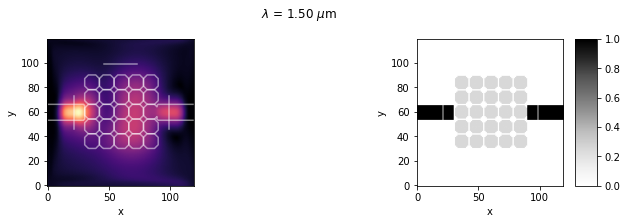

In [17]:
# Initialize the parametrization rho and the design region
epsrs = np.ones((num_dots, num_dots))*0.5
bg_rho, design_region, rods, input_slice, output_slice, ground_slice = init_domain(epsrs)

# Compute the permittivity from the design_region and the plasma rod permittivities
epsr_init = epsr_parameterization(epsrs, bg_rho, design_region, rods)

# Setup sources
source = insert_mode(omega1, dl, input_slice.x, input_slice.y, epsr_init, m=1)
probe = insert_mode(omega1, dl, output_slice.x, output_slice.y, epsr_init, m=1)
ground = insert_mode(omega1, dl, ground_slice.x, ground_slice.y, epsr_init, m=1)

# Simulate initial device
simulation, ax, fig = viz_sim(epsr_init, source, slices = [input_slice, output_slice, ground_slice])

In [18]:
def callback_output_structure(iteration, of_list, rho):
    """Callback function to output fields and the structures (for making sweet gifs)"""
    rho = epsrs.reshape((Nx, Ny))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    _, axs, fig = viz_sim(epsr, source, slices = [input_slice, output_slice])
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticks([])
    
    # note: make sure `workshop-invdesign/tmp` directory exists for this to work
    plt.savefig('tmp/epsr_%03d.png' % iteration, dpi=70)
    plt.close()

def callback_beta_schedule(iteration, of_list, epsrs):
    """Callback function for the optimizer to schedule changes to beta with the iteration number"""
    
    # I am commiting a terrible sin by using globals here, but I am feeling lazy...
    global beta
    
    if iteration < 50:
        beta = 100
    elif 50 <= iteration  & iteration < 75:
        beta = 100
    elif 75 <= iteration & iteration < 100:
        beta = 200
    else:
        beta = 300
    
    # Chain with the output structure callback
    callback_output_structure(iteration, of_list, epsrs)

In [19]:
# Define optimization objective
def mode_overlap(E1, E2):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(E1)*E2))*1e6

_, _, Ez00 = simulation.solve(source)
E00 = mode_overlap(Ez00, probe)
E11 = mode_overlap(Ez00, ground)

In [20]:
def objective1(epsrs):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    epsrs = epsrs.reshape((num_dots, num_dots))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    simulation.eps_r = epsr
    
    _, _, Ez00 = simulation.solve(source)
    return mode_overlap(Ez00, probe) / E00

# Compute the gradient of the objective function using revere-mode differentiation
objective1_jac = jacobian(objective1, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(epsrs_optimum, loss) = adam_optimize(objective1, epsrs.flatten(), objective1_jac,
                                      Nsteps=Nsteps, direction='max', step_size=step_size) #, callback=callback_beta_schedule)

Epoch:   1/200 | Duration: 8.33 secs | Value: 1.000000e+00
Epoch:   2/200 | Duration: 7.44 secs | Value: 1.001596e+00
Epoch:   3/200 | Duration: 8.76 secs | Value: 1.003191e+00
Epoch:   4/200 | Duration: 11.27 secs | Value: 1.004783e+00
Epoch:   5/200 | Duration: 8.48 secs | Value: 1.006373e+00
Epoch:   6/200 | Duration: 12.33 secs | Value: 1.007961e+00
Epoch:   7/200 | Duration: 9.51 secs | Value: 1.009547e+00
Epoch:   8/200 | Duration: 9.39 secs | Value: 1.011131e+00
Epoch:   9/200 | Duration: 12.31 secs | Value: 1.012712e+00
Epoch:  10/200 | Duration: 7.15 secs | Value: 1.014292e+00
Epoch:  11/200 | Duration: 6.71 secs | Value: 1.015870e+00
Epoch:  12/200 | Duration: 6.58 secs | Value: 1.017446e+00
Epoch:  13/200 | Duration: 6.94 secs | Value: 1.019022e+00
Epoch:  14/200 | Duration: 6.70 secs | Value: 1.020596e+00
Epoch:  15/200 | Duration: 6.77 secs | Value: 1.022170e+00
Epoch:  16/200 | Duration: 6.67 secs | Value: 1.023744e+00
Epoch:  17/200 | Duration: 6.58 secs | Value: 1.02531

Epoch: 140/200 | Duration: 14.93 secs | Value: 1.229306e+00
Epoch: 141/200 | Duration: 6.11 secs | Value: 1.230876e+00
Epoch: 142/200 | Duration: 6.33 secs | Value: 1.232436e+00
Epoch: 143/200 | Duration: 7.26 secs | Value: 1.233986e+00
Epoch: 144/200 | Duration: 5.76 secs | Value: 1.235524e+00
Epoch: 145/200 | Duration: 8.43 secs | Value: 1.237052e+00
Epoch: 146/200 | Duration: 6.59 secs | Value: 1.238568e+00
Epoch: 147/200 | Duration: 8.57 secs | Value: 1.240072e+00
Epoch: 148/200 | Duration: 6.00 secs | Value: 1.241564e+00
Epoch: 149/200 | Duration: 5.71 secs | Value: 1.243044e+00
Epoch: 150/200 | Duration: 6.13 secs | Value: 1.244512e+00
Epoch: 151/200 | Duration: 9.76 secs | Value: 1.245966e+00
Epoch: 152/200 | Duration: 8.90 secs | Value: 1.247408e+00
Epoch: 153/200 | Duration: 6.23 secs | Value: 1.248836e+00
Epoch: 154/200 | Duration: 6.64 secs | Value: 1.250251e+00
Epoch: 155/200 | Duration: 7.67 secs | Value: 1.251652e+00
Epoch: 156/200 | Duration: 5.71 secs | Value: 1.253039e

/home/aabdalla/miniconda/envs/mp/lib/python3.7/site-packages/ceviche/viz.py:37: UserWarning: No contour levels were found within the data range.
  ax.contour(outline.T, 0, colors='w', alpha=outline_alpha)


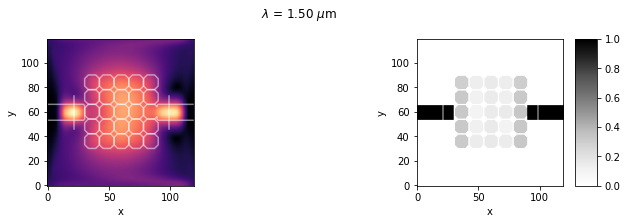

In [21]:
# Simulate optimal device
epsrs = epsrs_optimum.reshape((num_dots, num_dots))
epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
_, axs, fig = viz_sim(epsr, source, slices = [input_slice, output_slice])

In [10]:
def objective2(epsrs):
    """Objective function called by optimizer
    
    1) Takes the density distribution as input
    2) Constructs epsr
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    epsrs = epsrs.reshape((num_dots, num_dots))
    epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
    simulation.eps_r = epsr
    
    _, _, Ez11 = simulation.solve(source)
    return mode_overlap(Ez11, ground) / E11

# Compute the gradient of the objective function using revere-mode differentiation
objective2_jac = jacobian(objective2, mode='reverse')

# Maximize the objective function using an ADAM optimizer
(epsrs_optimum, loss) = adam_optimize(objective2, epsrs.flatten(), objective2_jac,
                                      Nsteps=Nsteps, direction='max', step_size=step_size) #, callback=callback_beta_schedule)

Epoch:   1/200 | Duration: 4.39 secs | Value: 1.236382e+00
Epoch:   2/200 | Duration: 4.43 secs | Value: 1.360406e+00
Epoch:   3/200 | Duration: 4.41 secs | Value: 1.484605e+00
Epoch:   4/200 | Duration: 2.83 secs | Value: 1.608936e+00
Epoch:   5/200 | Duration: 2.24 secs | Value: 1.733369e+00
Epoch:   6/200 | Duration: 2.02 secs | Value: 1.857877e+00
Epoch:   7/200 | Duration: 1.95 secs | Value: 1.982438e+00
Epoch:   8/200 | Duration: 2.16 secs | Value: 2.107032e+00
Epoch:   9/200 | Duration: 1.85 secs | Value: 2.231641e+00
Epoch:  10/200 | Duration: 2.65 secs | Value: 2.356249e+00
Epoch:  11/200 | Duration: 1.98 secs | Value: 2.480839e+00
Epoch:  12/200 | Duration: 1.74 secs | Value: 2.605397e+00
Epoch:  13/200 | Duration: 1.93 secs | Value: 2.729907e+00
Epoch:  14/200 | Duration: 1.73 secs | Value: 2.854356e+00
Epoch:  15/200 | Duration: 1.68 secs | Value: 2.978730e+00
Epoch:  16/200 | Duration: 1.68 secs | Value: 3.103015e+00
Epoch:  17/200 | Duration: 1.92 secs | Value: 3.227199e+

Epoch: 140/200 | Duration: 1.59 secs | Value: 1.593811e+01
Epoch: 141/200 | Duration: 1.53 secs | Value: 1.601902e+01
Epoch: 142/200 | Duration: 1.58 secs | Value: 1.609956e+01
Epoch: 143/200 | Duration: 1.54 secs | Value: 1.617972e+01
Epoch: 144/200 | Duration: 1.58 secs | Value: 1.625950e+01
Epoch: 145/200 | Duration: 1.63 secs | Value: 1.633890e+01
Epoch: 146/200 | Duration: 1.76 secs | Value: 1.641791e+01
Epoch: 147/200 | Duration: 2.47 secs | Value: 1.649652e+01
Epoch: 148/200 | Duration: 2.09 secs | Value: 1.657475e+01
Epoch: 149/200 | Duration: 2.30 secs | Value: 1.665257e+01
Epoch: 150/200 | Duration: 6.29 secs | Value: 1.672999e+01
Epoch: 151/200 | Duration: 4.41 secs | Value: 1.680701e+01
Epoch: 152/200 | Duration: 2.40 secs | Value: 1.688361e+01
Epoch: 153/200 | Duration: 2.75 secs | Value: 1.695980e+01
Epoch: 154/200 | Duration: 3.14 secs | Value: 1.703558e+01
Epoch: 155/200 | Duration: 5.42 secs | Value: 1.711093e+01
Epoch: 156/200 | Duration: 6.23 secs | Value: 1.718586e+

/home/aabdalla/miniconda/envs/mp/lib/python3.7/site-packages/ceviche/viz.py:37: UserWarning: No contour levels were found within the data range.
  ax.contour(outline.T, 0, colors='w', alpha=outline_alpha)


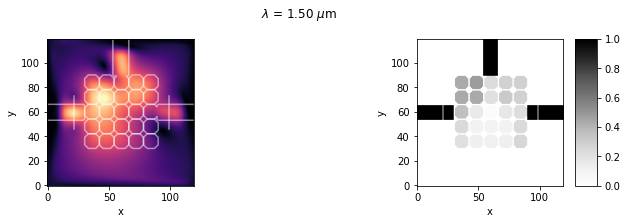

In [11]:
# Simulate optimal device
epsrs = epsrs_optimum.reshape((num_dots, num_dots))
epsr = epsr_parameterization(epsrs, bg_rho, design_region, rods)
_, axs, fig = viz_sim(epsr, source, slices = [input_slice, output_slice])